测试数据和训练数据分组，数据分batch

In [2]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
print(device)
# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('trainX_1024_10c')
    train_ylabel = load('trainY_1024_10c')
    # 验证集
    val_xdata = load('valX_1024_10c')
    val_ylabel = load('valY_1024_10c')
    # 测试集
    test_xdata = load('testX_1024_10c')
    test_ylabel = load('testY_1024_10c')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

cuda


In [ ]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
print(device)
# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('trainX_1024_10c')
    train_ylabel = load('trainY_1024_10c')
    # 验证集
    val_xdata = load('valX_1024_10c')
    val_ylabel = load('valY_1024_10c')
    # 测试集
    test_xdata = load('testX_1024_10c')
    test_ylabel = load('testY_1024_10c')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

cuda


In [ ]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
print(device)
# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('trainX_1024_10c')
    train_ylabel = load('trainY_1024_10c')
    # 验证集
    val_xdata = load('valX_1024_10c')
    val_ylabel = load('valY_1024_10c')
    # 测试集
    test_xdata = load('testX_1024_10c')
    test_ylabel = load('testY_1024_10c')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

cuda


In [3]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

50
14
7


定义交叉注意力机制

In [4]:
import torch
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(CrossAttention, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.value_dim = value_dim
        
        self.query_linear = nn.Linear(query_dim, query_dim)
        self.key_linear = nn.Linear(key_dim, query_dim)
        self.value_linear = nn.Linear(value_dim, query_dim)

    def forward(self, query, key, value):
        # 计算查询序列的注意力权重
        query_emb = self.query_linear(query)
        key_emb = self.key_linear(key)
        attention_weights = torch.bmm(query_emb, key_emb.transpose(1, 2))
        attention_weights = torch.softmax(attention_weights, dim=-1)
       
        # 根据注意力权重对值序列进行加权求和
        value_emb = self.value_linear(value)
        attended_values = torch.bmm(attention_weights, value_emb)

        return attended_values


定义FFT-CNN-BiLSTM-CrossAttention 网络架构

In [5]:
class FCNNBiLSTMCrossAttModel(nn.Module):
    def __init__(self, batch_size, timeconv_arch, spaceconv_arch,bilstm_hidden_layer_sizes, output_dim ,input_channels=1):
        """
        分类任务  params:
        batch_size                : 批次量大小
        timeconv_arch             : 一维时域信号 cnn 网络结构
        spaceconv_arch            : 一维频域信号 cnn 网络结构
        bilstm_hidden_layer_sizes : BiLSTM隐藏层的数目和维度
        output_dim                : 输出的维度
        input_channels            : CNN输入维度(通道数)
        """
        super().__init__()
        # 批次量大小
        self.batch_size = batch_size
        # time-cnn参数
        self.timeconv_arch = timeconv_arch  # 网络结构
        self.timeinput_channels = input_channels  # 输入通道数
        self.timefeatures = self.timecnnmake_layers()
        # space-cnn参数
        self.spaceconv_arch = spaceconv_arch  # 网络结构
        self.spaceinput_channels = input_channels  # 输入通道数
        self.spacefeatures = self.spacecnnmake_layers()

        # BiLSTM参数
        self.num_layers = len(bilstm_hidden_layer_sizes)  # BiLSTM层数
        self.timebilstm_layers = nn.ModuleList()  # 用于保存 时域信号 BiLSTM层的列表
        self.spacebilstm_layers = nn.ModuleList() # 用于保存 频域信号 BiLSTM层的列表
        # 定义time第一层BiLSTM
        self.timebilstm_layers.append(nn.LSTM(timeconv_arch[-1][-1], bilstm_hidden_layer_sizes[0], batch_first=True, bidirectional=True))
         # 定义后续的BiGRU层
        for i in range(1, self.num_layers):
                self.timebilstm_layers.append(nn.LSTM(bilstm_hidden_layer_sizes[i - 1] * 2, bilstm_hidden_layer_sizes[i], batch_first=True, bidirectional=True))
        
        # 定义space第一层BiLSTM
        self.spacebilstm_layers.append(nn.LSTM(spaceconv_arch[-1][-1], bilstm_hidden_layer_sizes[0], batch_first=True, bidirectional=True))
        # 定义后续的BiGRU层
        for i in range(1, self.num_layers):
                self.spacebilstm_layers.append(nn.LSTM(bilstm_hidden_layer_sizes[i - 1] * 2, bilstm_hidden_layer_sizes[i], batch_first=True, bidirectional=True))


        # 交叉注意力模块
        self.cross_attention = CrossAttention(bilstm_hidden_layer_sizes[-1] * 2, bilstm_hidden_layer_sizes[-1] * 2, 
                                              bilstm_hidden_layer_sizes[-1] * 2)  # # 双向LSTM 维度 * 2
       
        # 自适应平均池化
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # 定义全连接层
        self.classifier = nn.Linear(bilstm_hidden_layer_sizes[-1] * 2, output_dim) # 双向LSTM 维度*2
     
    
    # VGG卷积池化结构
    def timecnnmake_layers(self):
        layers = []
        for (num_convs, out_channels) in self.timeconv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.timeinput_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.timeinput_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.BatchNorm1d(out_channels))  # 添加批量归一化层
        return nn.Sequential(*layers)

    def spacecnnmake_layers(self):
        layers = []
        for (num_convs, out_channels) in self.spaceconv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.spaceinput_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.spaceinput_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.BatchNorm1d(out_channels))  # 添加批量归一化层
        return nn.Sequential(*layers)

    
    def forward(self, input_seq): 
       
        # 时序特征 卷积池化处理
        print(input_seq.size)
        time_input = input_seq.view(self.batch_size, 1, -1)  # -1表示自动计算缺失的维度 
        print(time_input.size)
        # CNN 1d卷积 网络输入 [batch,H_in, seq_length]
        time_features = self.timefeatures(time_input) 
        # print(time_features.size())   # torch.Size([32, 128, 129])
        # 调换维度[B, D, L] --> [B, L, D]
        time_features = time_features.permute(0,2,1)
        # Time-BiLSTM 处理
        time_bilstm_out = time_features
        for bilstm in self.timebilstm_layers:
            time_bilstm_out, _= bilstm(time_bilstm_out)  ## 进行一次BiLSTM层的前向传播   (b, l, w)
        # print(time_bilstm_out.size())   #  torch.Size([32, 129, 128])
     
       
        # 时域特征 卷积池化处理
        # 快速傅里叶变换
        fft_result = torch.fft.rfft(input_seq, dim=1)
        magnitude_spectrum = torch.abs(fft_result[:, :512])  #[256, 512]
        # 归一化操作
        # normalized_spectrum = F.normalize(magnitude_spectrum, p=2, dim=1)
        space_input = magnitude_spectrum.view(self.batch_size, 1, -1)  # torch.Size([32, 1, 512])
        # CNN 1d卷积 网络输入 [batch,H_in, seq_length]
        space_features = self.spacefeatures(space_input)   # torch.Size([32, 64, 65])
        # print(space_features.size())  # torch.Size([32, 64, 65])
        # 调换维度[B, D, L] --> [B, L, D]
        space_features = space_features.permute(0,2,1)
        # Space-BiLSTM 处理
        space_bilstm_out = space_features
        for bilstm in self.spacebilstm_layers:
            space_bilstm_out, _ = bilstm(space_bilstm_out)  ## 进行一次BiLSTM层的前向传播  
        # print(space_bilstm_out.size())   # torch.Size([32, 65, 128])

        # 注意力融合
        # 交叉注意力机制 cross_attention
        query = space_bilstm_out
        key = time_bilstm_out
        value = time_bilstm_out
        cross_attention_features = self.cross_attention(query, key, value)   # torch.Size([32, 65, 128])
        # print(cross_attention_features.size())   # torch.Size([32, 65, 128])

        # 自适应平均池化
        x = self.adaptive_pool(cross_attention_features.transpose(1, 2))  # torch.Size([32, 128, 1])
        # print(x.size()) # torch.Size([32, 128, 1])
        flat_tensor = x.reshape(self.batch_size, -1)
        outputs = self.classifier(flat_tensor) # torch.Size([32, 10] 
        return outputs

输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([32, 1024])    torch.Size([32])

In [6]:
# 定义 FCNNBiLSTMCrossAttModel 模型参数
batch_size = 32
# 时域 卷积参数
timeconv_arch = ((2, 32), (2, 64), (2, 128))  # CNN 层卷积池化结构  类似VGG
# 频域 卷积参数
spaceconv_arch =  ((2, 16), (2, 32), (2, 64))  # CNN 层卷积池化结构  类似VGG
# BiGRU 层数和维度数
bilstm_hidden_layer_sizes = [128, 64]
output_dim = 10 # 十分类

model = FCNNBiLSTMCrossAttModel(batch_size, timeconv_arch, spaceconv_arch,bilstm_hidden_layer_sizes, output_dim)  
# 定义损失函数和优化函数 
model = model.to(device)
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    96
    32
  3072
    32
    32
    32
  6144
    64
 12288
    64
    64
    64
 24576
   128
 49152
   128
   128
   128
    48
    16
   768
    16
    16
    16
  1536
    32
  3072
    32
    32
    32
  6144
    64
 12288
    64
    64
    64
 65536
 65536
   512
   512
 65536
 65536
   512
   512
 65536
 16384
   256
   256
 65536
 16384
   256
   256
 32768
 65536
   512
   512
 32768
 65536
   512
   512
 65536
 16384
   256
   256
 65536
 16384
   256
   256
 16384
   128
 16384
   128
 16384
   128
  1280
    10
______
963930


In [7]:
print(model)

FCNNBiLSTMCrossAttModel(
  (timefeatures): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU(inplace=True)
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): ReLU(inplace=True)
    (16): Conv1d(128, 128, kernel_size=(3,), stride=

注意调整参数，
1. 可以适当增加CNN 层数 和每层神经元个数，微调学习率；
2. 更改 BiLSTM维度和层数，增加更多的 epochs,  （注意防止过拟合）
3. 增加注意力层维度数

<built-in method size of Tensor object at 0x00000174A555F4A0>
<built-in method size of Tensor object at 0x00000174A555F9A0>
<built-in method size of Tensor object at 0x0000017443DE4F90>
<built-in method size of Tensor object at 0x00000174A863B950>
<built-in method size of Tensor object at 0x0000017443DE4F90>
<built-in method size of Tensor object at 0x00000174A863B270>
<built-in method size of Tensor object at 0x0000017443DE4EF0>
<built-in method size of Tensor object at 0x0000017443DE4F40>
<built-in method size of Tensor object at 0x0000017443DE4EF0>
<built-in method size of Tensor object at 0x00000174341070E0>
<built-in method size of Tensor object at 0x0000017443DE4EF0>
<built-in method size of Tensor object at 0x00000174341070E0>
<built-in method size of Tensor object at 0x0000017443DE4F40>
<built-in method size of Tensor object at 0x00000174A863BA40>
<built-in method size of Tensor object at 0x0000017443DE4F40>
<built-in method size of Tensor object at 0x00000174A866E590>
<built-i

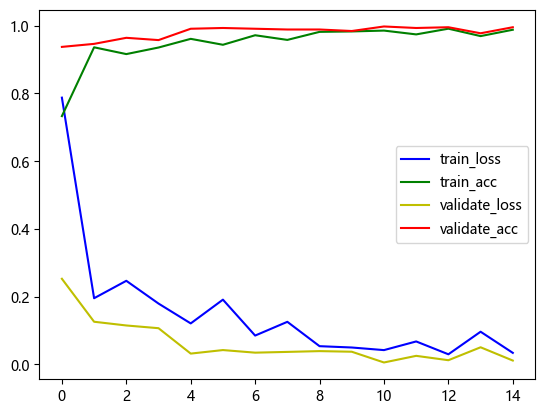

best_accuracy : 0.9977678571428571


In [8]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):

    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()
        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    # 保存最后的参数
    # torch.save(model, 'final_model_cnn_bilstm_catt.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_bilstm_catt.pt')
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



# batch_size = 32
epochs = 15
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [13]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import torch
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
print(device)

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_bilstm_catt.pt')
# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)


#编写一个测试样例，输入图片，输出故障类型
# 读取CSV文件
data = pd.read_csv('data_12k_10c.csv')

# 获取第一列作为测试数据
test_data = data.iloc[:, 2]
model.eval()
with torch.no_grad():
     test_data_tensor = torch.tensor([test_data]).float()
     #print(test_data_tensor)
     test_data_tensor = test_data_tensor.to(device)
     #print(test_data_tensor.size())
     test_output = model(test_data_tensor)
     #print(test_output.size())
     probabilities = F.softmax(test_output, dim=1)
     predicted = torch.argmax(probabilities, dim=1)
     predicted = predicted.mode().values.item()
     fault_mapping = {
    0: 'de_normal',
    1: 'de_7_inner',
    2: 'de_7_ball',
    3: 'de_7_outer',
    4: 'de_14_inner',
    5: 'de_14_ball',
    6: 'de_14_outer',
    7: 'de_21_inner',
    8: 'de_21_ball',
    9: 'de_21_outer'
}

predicted_fault = fault_mapping[predicted]
print(predicted_fault)

cuda
<built-in method size of Tensor object at 0x00000174A863B1D0>
<built-in method size of Tensor object at 0x0000017443A76040>
<built-in method size of Tensor object at 0x000001749F34B630>
<built-in method size of Tensor object at 0x00000174A86A2220>
<built-in method size of Tensor object at 0x00000174A86AEA90>
<built-in method size of Tensor object at 0x00000174A55DD360>
<built-in method size of Tensor object at 0x00000174A86AEA90>
<built-in method size of Tensor object at 0x00000174A86A8900>
<built-in method size of Tensor object at 0x00000174A86AEA90>
<built-in method size of Tensor object at 0x00000174A55DD360>
<built-in method size of Tensor object at 0x00000174A86AEA90>
<built-in method size of Tensor object at 0x00000174A86BB310>
<built-in method size of Tensor object at 0x00000174A86AEA90>
<built-in method size of Tensor object at 0x0000017443A76040>
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        24
           1     1

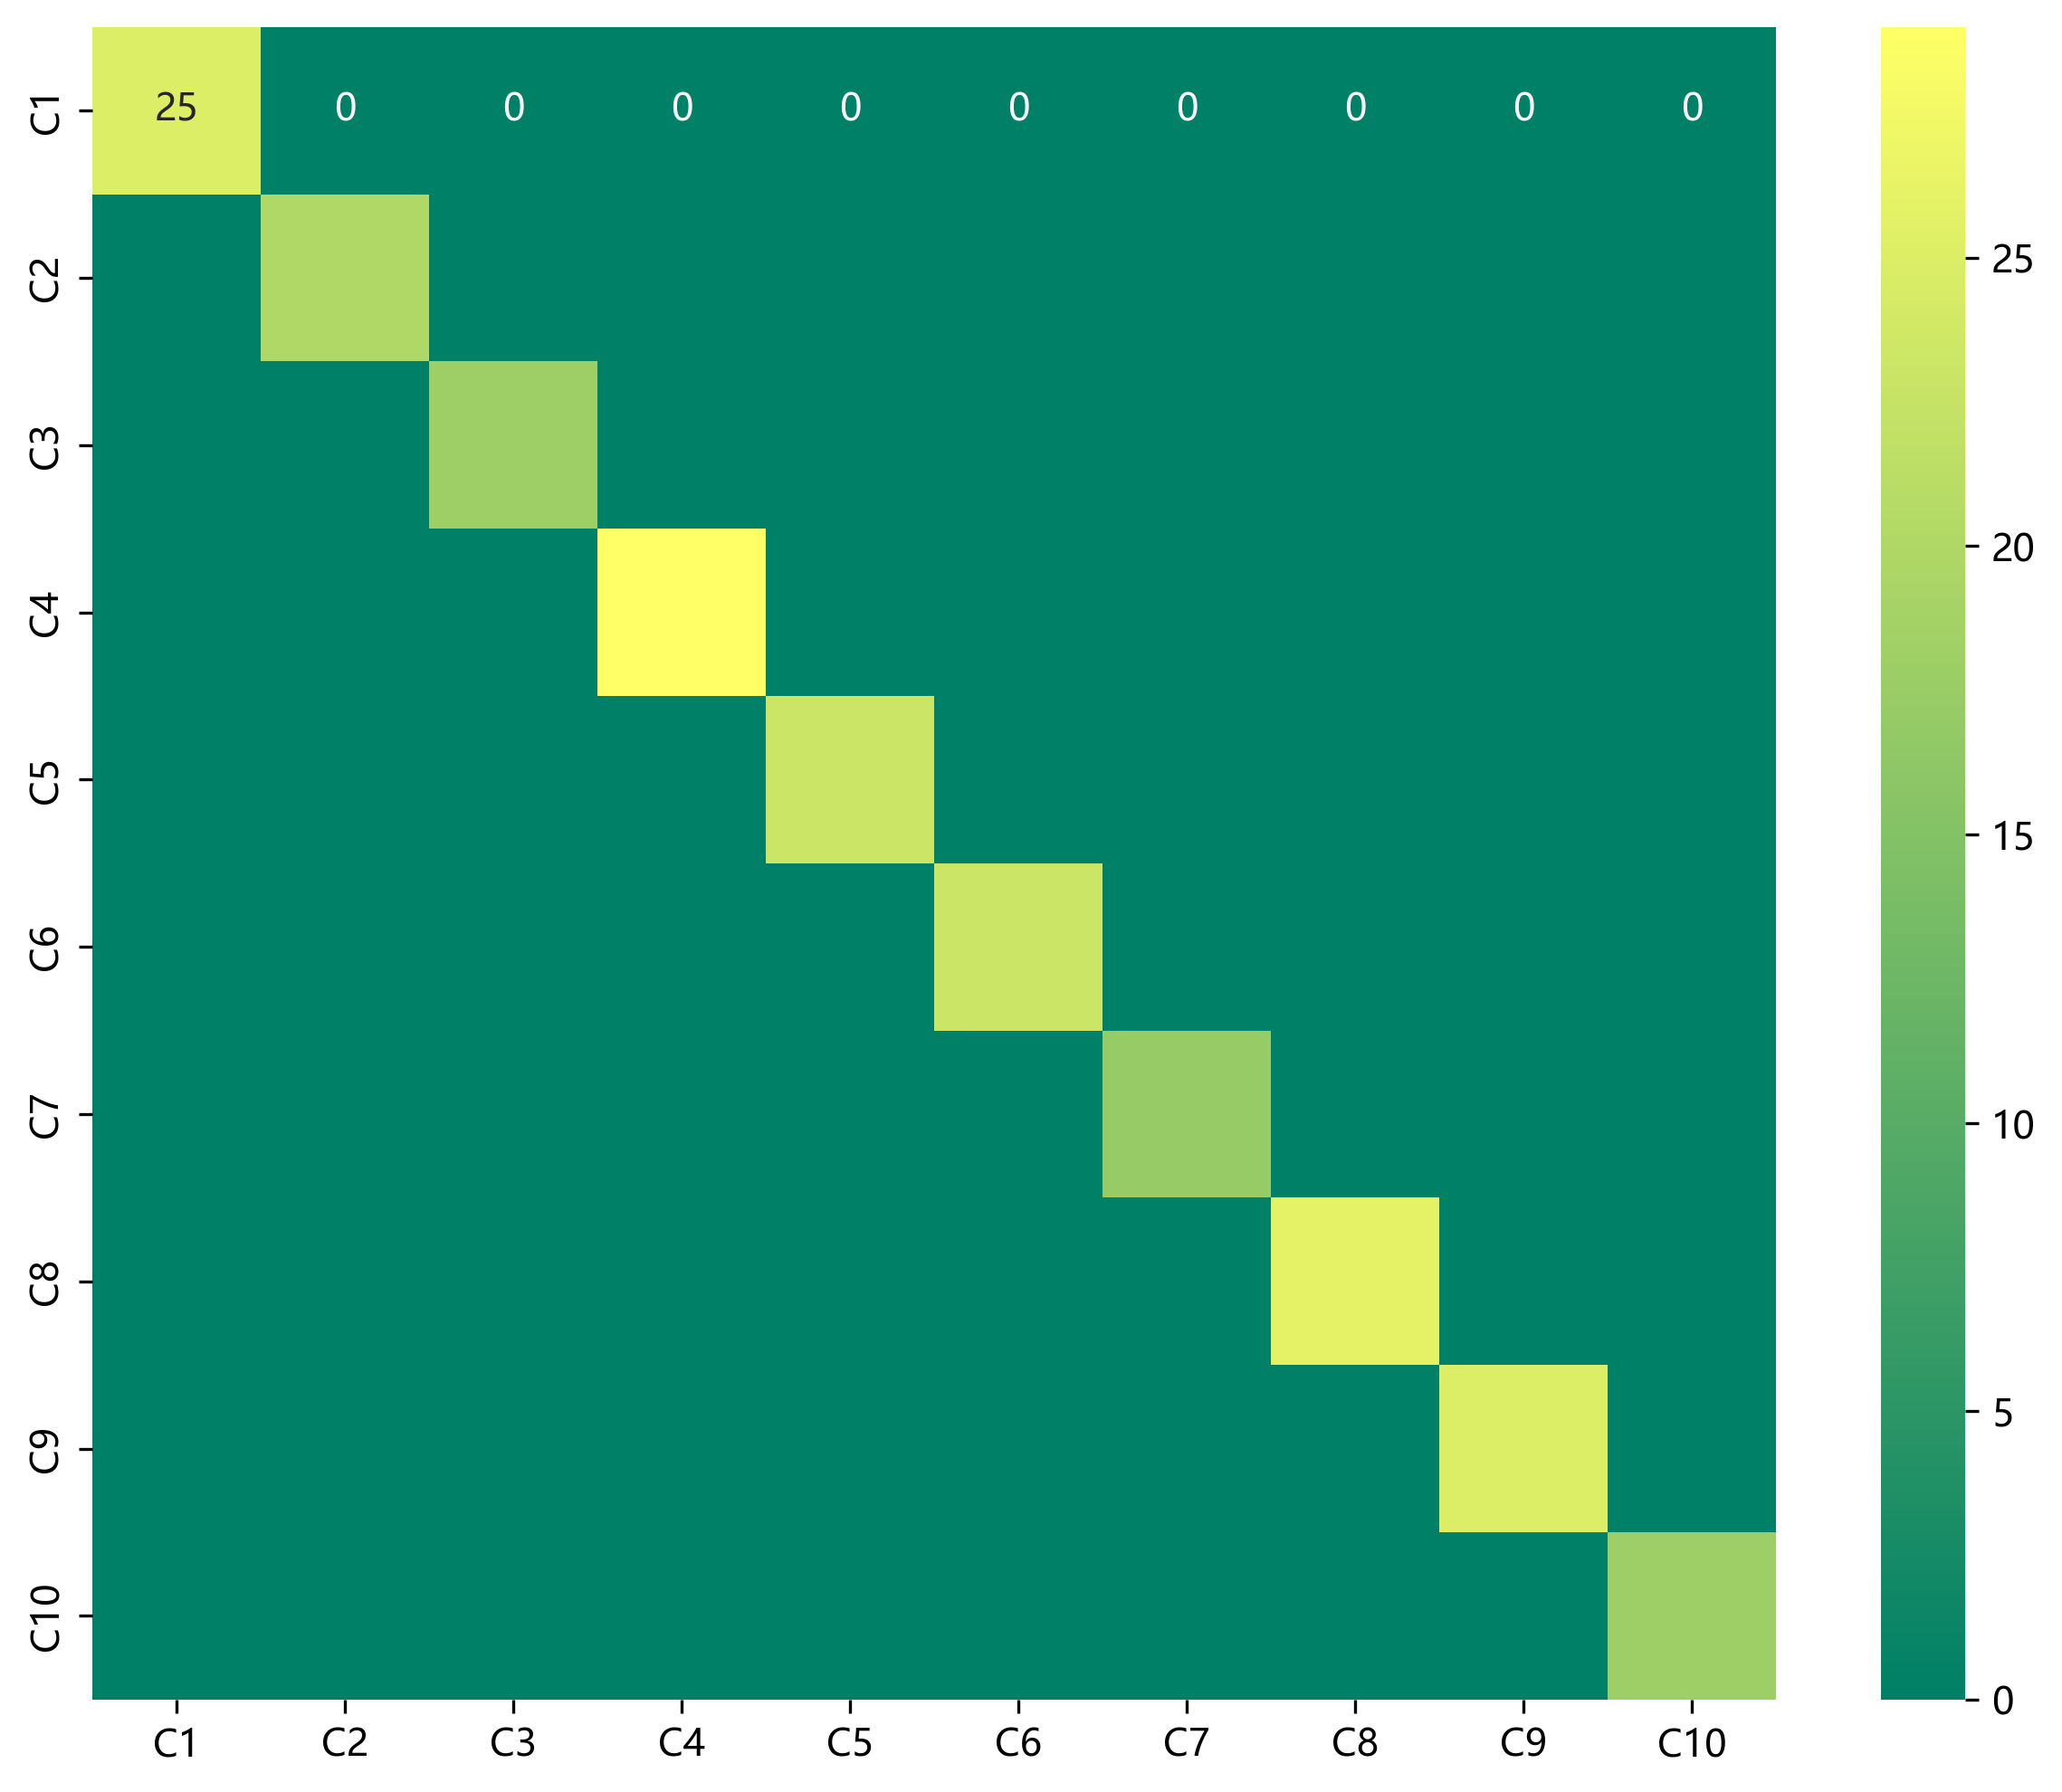

In [ ]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()